# Cancer Detection using CNNs

## Libraries Import

In [16]:
import pandas as pd
import os,shutil,math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc
import sklearn
from PIL import Image
from PIL import ImageDraw
import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

import h5py
import keras
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D, Conv2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

## Plotting functions

In [2]:
#----Custom function to visualize the training of the model------#
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
def show_multiple_history(h1,h2,h3,h4,h5):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(h1.epoch, h1.history["val_loss"], label="Validation loss")
    ax[0].plot(h1.epoch, h2.history["val_loss"], label="Validation loss")
    ax[0].plot(h1.epoch, h3.history["val_loss"], label="Validation loss")
    ax[0].plot(h1.epoch, h4.history["val_loss"], label="Validation loss")
    ax[0].plot(h1.epoch, h5.history["val_loss"], label="Validation loss")
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, h1.history["val_acc"], label="Validation acc")
    ax[1].plot(history.epoch, h2.history["val_acc"], label="Validation acc")
    ax[1].plot(history.epoch, h3.history["val_acc"], label="Validation acc")
    ax[1].plot(history.epoch, h4.history["val_acc"], label="Validation acc")
    ax[1].plot(history.epoch, h5.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


## Dataset Import

### Dataset Directories 

In [ ]:
Input_DIR = 'D:\Documents\Queens Masc\Winter 2019\CISC 867 - Deep Learning\Course Project\Datasets'
Training_DIR = Input_DIR + '\Training\train'
Testing_DIR = Input_DIR + '\Testing\test'
Trainlabels_DIR = Input_DIR + '\\Training\\train_labels.csv'

### Model saved files

In [3]:
#Specify the files names for the model data and parameters
#VGG Baseline model training file
TRAINING_LOGS_FILE_modelvgg = "training_logs_modelvgg.csv"
#Inception Baseline model training file
TRAINING_LOGS_FILE_modelinception = "training_logs_modelinception.csv"
#Ressnet50 Baseline model training file
TRAINING_LOGS_FILE_modelressnet = "training_logs_modelressnet.csv"
#DenseNet 201 Baseline model training file
TRAINING_LOGS_FILE_modeldensenet = "training_logs_modeldensenet.csv"
#VGG Baseline model summary 
MODEL_SUMMARY_FILE_vgg = "model_summary_vgg.txt"
#Inception Baseline model summary 
MODEL_SUMMARY_FILE_inception = "model_summary_Inception.txt"
#Ressnet50 Baseline model summary 
MODEL_SUMMARY_FILE_Ressnet = "model_summary_Ressnet.txt"
#DenseNet Baseline model summary 
MODEL_SUMMARY_FILE_DenseNet = "model_summary_DenseNet.txt"
# Vgg BaselineModel history file
MODEL_FILE_vgg = "histopathologic_cancer_detector_vgg.h5"
# Inception BaselineModel history file
MODEL_FILE_Inception = "histopathologic_cancer_detector_Inception.h5"
# Ressnet50 BaselineModel history file
MODEL_FILE_Ressnet = "histopathologic_cancer_detector_Ressnet.h5"
# DenseNet BaselineModel history file
MODEL_FILE_DenseNet = "histopathologic_cancer_detector_DenseNet.h5"

#TRAINING_PLOT_FILE = "training.png"
#Plot validation accuracy
VALIDATION_PLOT_FILE = "validation.png"
# Plot ROC Curve
ROC_PLOT_FILE = "roc.png"
# Sample numbers for non-augmented data 
SAMPLE_COUNT_original = 60000
TESTING_BATCH_SIZE_original = 5000
# Sample Numbers for augmentation
SAMPLE_COUNT_augmentation = 60000
TESTING_BATCH_SIZE_augmentation = 5000


### Import Dataset
Do it for the first time only and then load for testing from the pickle files.


In [ ]:
#Import Training data as dataframe
Training_Data = pd.DataFrame({'path': glob.glob(('D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\Training\\train\\**\\*.tif'),recursive=True)})
#Training_Data = Training_Data.drop(0,axis=0)

In [ ]:
# Save the images Ids in a column ID
Training_Data ['id'] = Training_Data.path.map(lambda x: x.split('\\')[9].split('.')[0])
# Save the Images labels in a dataframe labels column
Training_Labels = pd.read_csv(Trainlabels_DIR, encoding='latin1')

In [ ]:
# merge the training labels with the training dataframe
Training_Data = Training_Data.merge(Training_Labels, on='id')

In [ ]:
# Save the negative and postive labels training data in new dataframes
negative_train_cancer_original = Training_Data[Training_Data.label == 0].sample(SAMPLE_COUNT_original, replace=True)
positive_train_cancer_original = Training_Data[Training_Data.label == 1].sample(SAMPLE_COUNT_original, replace=True)

In [ ]:
# Read Images in a new column
Training_Data_sample_original = pd.concat([negative_train_cancer_original,positive_train_cancer_original])
Training_Data_sample_original = Training_Data_sample_original[['path','id','label']]
Training_Data_sample_original['image'] = Training_Data_sample_original['path'].map(imread)

In [ ]:
print(len(Training_Data_sample_original))
print(Training_Data_sample_original.dtypes)

In [ ]:
Training_Data_sample_original.to_pickle('D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\Training_Data_sample_original.pkl')

### Split Training/ Validation/Testing
Do it for the first time only and then load for testing from the pickle files.

In [ ]:
# New paths for the training and validation sets.
train_path_original = 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\newtraining'
val_path_original = 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\validation'
test_path_original = 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\newtesting'
#generate folders with the binary labels
for directory in [train_path_original,val_path_original,test_path_original]:
    for sub_directory in ['[0]','[1]']:
        path = os.path.join(directory,sub_directory)
        os.makedirs(path,exist_ok=True)
# get a validation set from the training data with percentage 20%
Trainnn =  Training_Data_sample_original  
Training_input_split,validation_input_original = train_test_split(Trainnn,train_size=0.9,stratify=Trainnn['label'])
Training_input_split,Test_input_original = train_test_split(Training_input_split,train_size=0.9,stratify=Training_input_split['label'])

#Training_Data_sample=Training_Data_sample.set_index('id',inplace=True)
#print(Training_Data_sample)
# put the dataset in labeled folders
for images_paths in [(Training_input_split,train_path_original),(validation_input_original,val_path_original),(Test_input_original,test_path_original)]:
    images = images_paths[0]
    path = images_paths[1]
    for image in images['id'].values:
        file_name = image + '.tif'
        label = Training_Data_sample_original.loc[Training_Data_sample_original['id'] == image ,'label'].values[0]
        label_name = "["+ str(label) + "]"
        print(label_name)
        destination = os.path.join(path,label_name,file_name)
        if not os.path.exists(destination):
            source = os.path.join('D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\Training\\train',file_name)
            shutil.copyfile(source,destination)

In [ ]:
Training_input_split.to_pickle('D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\Training_input_split.pkl')
Test_input_original.to_pickle('D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\Test_input_original.pkl')
validation_input_original.to_pickle('D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\validation_input_original.pkl')


## Load For Testing

In [4]:
Training_input_split = pd.read_pickle('D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\Training_input_split.pkl')
Test_input_original = pd.read_pickle('D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\Test_input_original.pkl')
validation_input_original = pd.read_pickle('D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\validation_input_original.pkl')

### Original Data as Numpy Arrays
Do it for the first time only and then save them as npy files.

In [5]:
X_train = np.stack(Training_input_split.image.values)
Y_train = np.stack(Training_input_split.label.values)
X_validate = np.stack(validation_input_original.image.values)
Y_validate = np.stack(validation_input_original.label.values)
X_test = np.stack(Test_input_original.image.values)
Y_test = np.stack(Test_input_original.label.values)


In [6]:
print (Training_input_split.image.values)
np.save( 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\X_train.npy',X_train)
np.save( 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\Y_train.npy',Y_train)
np.save( 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\X_validate.npy',X_validate)
np.save( 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\Y_validate.npy',Y_validate)
np.save( 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\X_test.npy',X_test)
np.save( 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\Y_test.npy',Y_test)


In [4]:
X_train = np.load( 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\X_train.npy')
Y_train = np.load( 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\Y_train.npy')
X_validate = np.load( 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\X_validate.npy')
Y_validate = np.load( 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\Y_validate.npy')
X_test = np.load( 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\X_test.npy')
Y_test = np.load( 'D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\Datasets\\Y_test.npy')


print (X_train.shape)
print (Y_train.shape)
print (X_validate.shape)
print (Y_validate.shape)
print (X_test.shape)
print (Y_test.shape)

(97200, 96, 96, 3)
(97200,)
(12000, 96, 96, 3)
(12000,)
(10800, 96, 96, 3)
(10800,)


## Start a Tensorflow session

In [5]:
# Specify computation power for the training
import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
import keras
from keras import backend as K
# K.tensorflow_backend._get_available_gpus()
# config = tf.ConfigProto( device_count = {'GPU': 1 } ) 
# sess = tf.Session(config=config) 
# keras.backend.set_session(sess)

init_op = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init_op)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


## Processing Pipeleine (Model functions)

### - VGG19 model

In [30]:
# base model is VGG19
def vgg_callbacks ():

    # Early Stopping Condition: Validation loss with minimum change 0.001 and waiting of 10 steps after condition occurs
    vgg_earlystop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=2,
        verbose=1,
        mode='auto'
    )
    # tensorboard visualization
    vgg_tensorboard = TensorBoard(
        log_dir = './logs',
        histogram_freq=0,
        batch_size=100,
        write_graph=True,
        write_grads=True,
        write_images=False,
    )
    #log in csv file
    vgg_csvlogger = CSVLogger(
        filename= TRAINING_LOGS_FILE_modelvgg,
        separator = ",",
        append = False
    )


    vgg_callbacks = [vgg_earlystop,vgg_tensorboard,vgg_csvlogger]
    return vgg_callbacks



def vgg_model (neurons):
    
    vgg_base_model = VGG19(include_top=False,
                  input_shape = (96,96,3),
                  weights = 'imagenet')
    
    vgg_model = Sequential()
    vgg_model.add(vgg_base_model)
    vgg_model.add(BatchNormalization())
    vgg_model.add(Flatten())
    vgg_model.add(Dense((int(neurons)),
                        activation='relu'))
    vgg_model.add(Dropout(0.5))    
    vgg_model.add(Dense((int(neurons/2)),
                        activation='relu'))
    vgg_model.add(Dropout(0.5))
    vgg_model.add(Dense(1,activation='sigmoid'))
    vgg_model.summary()
    return vgg_model


### - DenseNet model

In [31]:
def Dense_callbacks ():
    # Early Stopping Condition: Validation loss with minimum change 0.001 and waiting of 10 steps after condition occurs
    dense_earlystop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=2,
        verbose=1,
        mode='auto'
    )
    # tensorboard visualization
    dense_tensorboard = TensorBoard(
        log_dir = './logs',
        histogram_freq=0,
        batch_size=100,
        write_graph=True,
        write_grads=True,
        write_images=False,
    )
    #log in csv file
    dense_csvlogger = CSVLogger(
        filename= TRAINING_LOGS_FILE_modeldensenet,
        separator = ",",
        append = False
    )

    dense_callbacks = [dense_earlystop,dense_tensorboard,dense_csvlogger]
    return dense_callbacks



def dense_model (neurons):
    dense_base_model = keras.applications.densenet.DenseNet121(include_top=False,
                  input_shape = (96,96,3),
                  weights = 'imagenet')

    

    dense_model = Sequential()
    dense_model.add(dense_base_model)
    dense_model.add(BatchNormalization())
    dense_model.add(Flatten())
    dense_model.add(Dense((int(neurons)),
                        activation='relu'))
    dense_model.add(Dropout(0.5))    
    dense_model.add(Dense((int(neurons/2)),
                        activation='relu'))
    dense_model.add(Dropout(0.5))
    dense_model.add(Dense(1,activation='sigmoid'))
    dense_model.summary()
    return dense_model


### - ResNet

In [32]:
def res_callbacks ():
    # Early Stopping Condition: Validation loss with minimum change 0.001 and waiting of 10 steps after condition occurs
    res_earlystop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=2,
        verbose=1,
        mode='auto'
    )
    # tensorboard visualization
    res_tensorboard = TensorBoard(
        log_dir = './logs',
        histogram_freq=0,
        batch_size=100,
        write_graph=True,
        write_grads=True,
        write_images=False,
    )
    #log in csv file
    res_csvlogger = CSVLogger(
        filename= TRAINING_LOGS_FILE_modelressnet,
        separator = ",",
        append = False
    )


    res_callbacks = [res_earlystop,res_tensorboard,res_csvlogger]
    return res_callbacks



def res_model (neurons):

    res_base_model = keras.applications.resnet50 .ResNet50(include_top=False,
                  input_shape = (96,96,3),
                  weights = 'imagenet')

    

    res_model = Sequential()
    res_model.add(res_base_model)
    res_model.add(BatchNormalization())
    res_model.add(Flatten())
    res_model.add(Dense((int(neurons)),
                        activation='relu'))
    res_model.add(Dropout(0.5))    
    res_model.add(Dense((int(neurons/2)),
                        activation='relu'))
    res_model.add(Dropout(0.5))
    res_model.add(Dense(1,activation='sigmoid'))
    res_model.summary()
    return res_model


### - Inception Model

In [33]:
def inception_callbacks ():
    # Early Stopping Condition: Validation loss with minimum change 0.001 and waiting of 10 steps after condition occurs
    inception_earlystop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=2,
        verbose=1,
        mode='auto'
    )
    # tensorboard visualization
    inception_tensorboard = TensorBoard(
        log_dir = './logs',
        histogram_freq=0,
        batch_size=100,
        write_graph=True,
        write_grads=True,
        write_images=False,
    )
    #log in csv file
    inception_csvlogger = CSVLogger(
        filename= TRAINING_LOGS_FILE_modelinception,
        separator = ",",
        append = False
    )
    inception_callbacks = [inception_earlystop,inception_tensorboard,inception_csvlogger]
    return inception_callbacks



def inception_model (neurons):
    inception_base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False,
                  input_shape = (96,96,3),
                  weights = 'imagenet')

    

    inception_model = Sequential()
    inception_model.add(inception_base_model)
    inception_model.add(BatchNormalization())
    inception_model.add(Flatten())
    inception_model.add(Dense((int(neurons)),
                        activation='relu'))
    inception_model.add(Dropout(0.5))    
    inception_model.add(Dense((int(neurons/2)),
                        activation='relu'))
    inception_model.add(Dropout(0.5))
    inception_model.add(Dense(1,activation='sigmoid'))
    inception_model.summary()
    return inception_model


#### General Parameters for Comparison

In [34]:

lr  = 1e-6
neurons = 1024 
momentum = 0.99
opt_SGD = SGD(lr=1e-6,momentum=0.99)
opt_Adam = Adam(lr=2e-6)
batch_size = 64
epochs = 10

## Models Training and Testing

### VGG19 model training and testing on non-augmented data 

#### Original Data Training and Testing

In [35]:
###
vgg_model_callback = vgg_callbacks()
vgg_model_train = vgg_model (neurons)


vgg_model_train.compile(
    loss='binary_crossentropy',
    optimizer=opt_Adam,
    metrics=['accuracy']
)
    


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
batch_normalization_204 (Bat (None, 3, 3, 512)         2048      
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
__________

In [12]:
#Load weights 
vgg_model_train.load_weights("D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\models\\vgg\\Vgg_model_history_original_weights.h5")


In [20]:
# Training
Vgg_model_history_original = vgg_model_train.fit(X_train, Y_train, epochs = epochs,validation_data=(X_validate,Y_validate),shuffle=True,batch_size=batch_size, callbacks = vgg_model_callback ,verbose = 1)


Instructions for updating:
Use tf.cast instead.
Train on 97200 samples, validate on 12000 samples
Epoch 1/10


13056/97200 [===>..........................] - ETA: 2:36:43 - loss: 0.2652 - acc: 0.92 - ETA: 1:24:15 - loss: 0.2472 - acc: 0.91 - ETA: 1:00:06 - loss: 0.2402 - acc: 0.90 - ETA: 48:01 - loss: 0.2034 - acc: 0.9219 - ETA: 40:45 - loss: 0.1946 - acc: 0.92 - ETA: 35:57 - loss: 0.2039 - acc: 0.91 - ETA: 32:28 - loss: 0.1928 - acc: 0.92 - ETA: 29:53 - loss: 0.2030 - acc: 0.92 - ETA: 27:52 - loss: 0.2191 - acc: 0.91 - ETA: 26:14 - loss: 0.2242 - acc: 0.91 - ETA: 24:55 - loss: 0.2204 - acc: 0.91 - ETA: 23:48 - loss: 0.2128 - acc: 0.91 - ETA: 22:52 - loss: 0.2068 - acc: 0.92 - ETA: 22:03 - loss: 0.2043 - acc: 0.92 - ETA: 21:21 - loss: 0.2075 - acc: 0.91 - ETA: 20:45 - loss: 0.2038 - acc: 0.91 - ETA: 20:12 - loss: 0.2063 - acc: 0.91 - ETA: 19:43 - loss: 0.2088 - acc: 0.91 - ETA: 19:17 - loss: 0.2048 - acc: 0.91 - ETA: 18:54 - loss: 0.2112 - acc: 0.91 - ETA: 18:33 - loss: 0.2101 - acc: 0.91 - ETA: 18:13 - loss: 0.2099 - acc: 0.91 - ETA: 17:56 - loss: 0.2098 - acc: 0.91 - ETA: 17:39 - loss: 0.2075

78336/97200 [=======================>......] - ETA: 4:01 - loss: 0.1772 - acc: 0.932 - ETA: 4:01 - loss: 0.1772 - acc: 0.932 - ETA: 4:01 - loss: 0.1771 - acc: 0.932 - ETA: 4:00 - loss: 0.1771 - acc: 0.932 - ETA: 4:00 - loss: 0.1770 - acc: 0.932 - ETA: 3:59 - loss: 0.1769 - acc: 0.932 - ETA: 3:59 - loss: 0.1769 - acc: 0.932 - ETA: 3:58 - loss: 0.1770 - acc: 0.932 - ETA: 3:58 - loss: 0.1770 - acc: 0.932 - ETA: 3:57 - loss: 0.1770 - acc: 0.932 - ETA: 3:57 - loss: 0.1771 - acc: 0.932 - ETA: 3:56 - loss: 0.1772 - acc: 0.932 - ETA: 3:56 - loss: 0.1771 - acc: 0.932 - ETA: 3:55 - loss: 0.1771 - acc: 0.932 - ETA: 3:55 - loss: 0.1772 - acc: 0.932 - ETA: 3:54 - loss: 0.1772 - acc: 0.932 - ETA: 3:54 - loss: 0.1771 - acc: 0.932 - ETA: 3:53 - loss: 0.1772 - acc: 0.932 - ETA: 3:53 - loss: 0.1771 - acc: 0.932 - ETA: 3:52 - loss: 0.1770 - acc: 0.932 - ETA: 3:52 - loss: 0.1770 - acc: 0.932 - ETA: 3:51 - loss: 0.1769 - acc: 0.932 - ETA: 3:51 - loss: 0.1769 - acc: 0.932 - ETA: 3:50 - loss: 0.1767 - acc: 0

91520/97200 [===========================>..] - ETA: 2:22 - loss: 0.1750 - acc: 0.933 - ETA: 2:22 - loss: 0.1750 - acc: 0.933 - ETA: 2:21 - loss: 0.1749 - acc: 0.933 - ETA: 2:21 - loss: 0.1749 - acc: 0.933 - ETA: 2:20 - loss: 0.1749 - acc: 0.933 - ETA: 2:20 - loss: 0.1749 - acc: 0.933 - ETA: 2:19 - loss: 0.1748 - acc: 0.933 - ETA: 2:19 - loss: 0.1748 - acc: 0.933 - ETA: 2:18 - loss: 0.1748 - acc: 0.934 - ETA: 2:18 - loss: 0.1748 - acc: 0.934 - ETA: 2:17 - loss: 0.1748 - acc: 0.934 - ETA: 2:17 - loss: 0.1748 - acc: 0.934 - ETA: 2:16 - loss: 0.1748 - acc: 0.934 - ETA: 2:16 - loss: 0.1748 - acc: 0.934 - ETA: 2:15 - loss: 0.1748 - acc: 0.934 - ETA: 2:15 - loss: 0.1749 - acc: 0.934 - ETA: 2:14 - loss: 0.1748 - acc: 0.934 - ETA: 2:14 - loss: 0.1748 - acc: 0.934 - ETA: 2:14 - loss: 0.1747 - acc: 0.934 - ETA: 2:13 - loss: 0.1747 - acc: 0.934 - ETA: 2:13 - loss: 0.1747 - acc: 0.934 - ETA: 2:12 - loss: 0.1746 - acc: 0.934 - ETA: 2:12 - loss: 0.1746 - acc: 0.934 - ETA: 2:11 - loss: 0.1745 - acc: 0

97200/97200 [==============================] - ETA: 42s - loss: 0.1731 - acc: 0.93 - ETA: 42s - loss: 0.1731 - acc: 0.93 - ETA: 41s - loss: 0.1732 - acc: 0.93 - ETA: 41s - loss: 0.1732 - acc: 0.93 - ETA: 40s - loss: 0.1731 - acc: 0.93 - ETA: 40s - loss: 0.1731 - acc: 0.93 - ETA: 39s - loss: 0.1731 - acc: 0.93 - ETA: 39s - loss: 0.1731 - acc: 0.93 - ETA: 38s - loss: 0.1730 - acc: 0.93 - ETA: 38s - loss: 0.1729 - acc: 0.93 - ETA: 37s - loss: 0.1730 - acc: 0.93 - ETA: 37s - loss: 0.1729 - acc: 0.93 - ETA: 36s - loss: 0.1728 - acc: 0.93 - ETA: 36s - loss: 0.1728 - acc: 0.93 - ETA: 35s - loss: 0.1727 - acc: 0.93 - ETA: 35s - loss: 0.1726 - acc: 0.93 - ETA: 34s - loss: 0.1726 - acc: 0.93 - ETA: 34s - loss: 0.1726 - acc: 0.93 - ETA: 33s - loss: 0.1725 - acc: 0.93 - ETA: 33s - loss: 0.1725 - acc: 0.93 - ETA: 32s - loss: 0.1725 - acc: 0.93 - ETA: 32s - loss: 0.1725 - acc: 0.93 - ETA: 31s - loss: 0.1725 - acc: 0.93 - ETA: 31s - loss: 0.1725 - acc: 0.93 - ETA: 30s - loss: 0.1725 - acc: 0.93 - ETA

13056/97200 [===>..........................] - ETA: 12:02 - loss: 0.2780 - acc: 0.90 - ETA: 12:00 - loss: 0.2017 - acc: 0.92 - ETA: 12:00 - loss: 0.1693 - acc: 0.94 - ETA: 12:00 - loss: 0.1811 - acc: 0.92 - ETA: 12:00 - loss: 0.1656 - acc: 0.94 - ETA: 11:59 - loss: 0.1620 - acc: 0.93 - ETA: 11:59 - loss: 0.1552 - acc: 0.94 - ETA: 11:58 - loss: 0.1509 - acc: 0.94 - ETA: 11:58 - loss: 0.1521 - acc: 0.94 - ETA: 11:57 - loss: 0.1463 - acc: 0.94 - ETA: 11:57 - loss: 0.1493 - acc: 0.94 - ETA: 11:56 - loss: 0.1661 - acc: 0.94 - ETA: 11:56 - loss: 0.1590 - acc: 0.94 - ETA: 11:55 - loss: 0.1626 - acc: 0.94 - ETA: 11:55 - loss: 0.1598 - acc: 0.94 - ETA: 11:54 - loss: 0.1564 - acc: 0.94 - ETA: 11:54 - loss: 0.1526 - acc: 0.94 - ETA: 11:53 - loss: 0.1485 - acc: 0.94 - ETA: 11:53 - loss: 0.1468 - acc: 0.94 - ETA: 11:52 - loss: 0.1502 - acc: 0.94 - ETA: 11:52 - loss: 0.1490 - acc: 0.94 - ETA: 11:51 - loss: 0.1504 - acc: 0.94 - ETA: 11:51 - loss: 0.1504 - acc: 0.94 - ETA: 11:50 - loss: 0.1506 - acc: 

78336/97200 [=======================>......] - ETA: 4:01 - loss: 0.1558 - acc: 0.941 - ETA: 4:00 - loss: 0.1559 - acc: 0.941 - ETA: 4:00 - loss: 0.1560 - acc: 0.941 - ETA: 3:59 - loss: 0.1560 - acc: 0.941 - ETA: 3:59 - loss: 0.1561 - acc: 0.941 - ETA: 3:58 - loss: 0.1560 - acc: 0.941 - ETA: 3:58 - loss: 0.1559 - acc: 0.941 - ETA: 3:57 - loss: 0.1559 - acc: 0.941 - ETA: 3:57 - loss: 0.1559 - acc: 0.941 - ETA: 3:56 - loss: 0.1559 - acc: 0.941 - ETA: 3:56 - loss: 0.1559 - acc: 0.941 - ETA: 3:55 - loss: 0.1559 - acc: 0.941 - ETA: 3:55 - loss: 0.1559 - acc: 0.941 - ETA: 3:54 - loss: 0.1562 - acc: 0.941 - ETA: 3:54 - loss: 0.1561 - acc: 0.941 - ETA: 3:53 - loss: 0.1561 - acc: 0.941 - ETA: 3:53 - loss: 0.1561 - acc: 0.941 - ETA: 3:53 - loss: 0.1560 - acc: 0.941 - ETA: 3:52 - loss: 0.1559 - acc: 0.941 - ETA: 3:52 - loss: 0.1559 - acc: 0.941 - ETA: 3:51 - loss: 0.1559 - acc: 0.942 - ETA: 3:51 - loss: 0.1559 - acc: 0.941 - ETA: 3:50 - loss: 0.1559 - acc: 0.941 - ETA: 3:50 - loss: 0.1559 - acc: 0

91520/97200 [===========================>..] - ETA: 2:22 - loss: 0.1563 - acc: 0.942 - ETA: 2:21 - loss: 0.1562 - acc: 0.942 - ETA: 2:21 - loss: 0.1562 - acc: 0.942 - ETA: 2:20 - loss: 0.1562 - acc: 0.942 - ETA: 2:20 - loss: 0.1563 - acc: 0.942 - ETA: 2:20 - loss: 0.1562 - acc: 0.942 - ETA: 2:19 - loss: 0.1562 - acc: 0.942 - ETA: 2:19 - loss: 0.1563 - acc: 0.942 - ETA: 2:18 - loss: 0.1563 - acc: 0.942 - ETA: 2:18 - loss: 0.1564 - acc: 0.942 - ETA: 2:17 - loss: 0.1564 - acc: 0.942 - ETA: 2:17 - loss: 0.1564 - acc: 0.942 - ETA: 2:16 - loss: 0.1564 - acc: 0.942 - ETA: 2:16 - loss: 0.1564 - acc: 0.942 - ETA: 2:15 - loss: 0.1564 - acc: 0.942 - ETA: 2:15 - loss: 0.1564 - acc: 0.942 - ETA: 2:14 - loss: 0.1564 - acc: 0.942 - ETA: 2:14 - loss: 0.1563 - acc: 0.942 - ETA: 2:13 - loss: 0.1562 - acc: 0.942 - ETA: 2:13 - loss: 0.1562 - acc: 0.942 - ETA: 2:12 - loss: 0.1562 - acc: 0.942 - ETA: 2:12 - loss: 0.1562 - acc: 0.942 - ETA: 2:11 - loss: 0.1561 - acc: 0.942 - ETA: 2:11 - loss: 0.1561 - acc: 0

97200/97200 [==============================] - ETA: 42s - loss: 0.1545 - acc: 0.94 - ETA: 42s - loss: 0.1544 - acc: 0.94 - ETA: 41s - loss: 0.1545 - acc: 0.94 - ETA: 41s - loss: 0.1545 - acc: 0.94 - ETA: 40s - loss: 0.1545 - acc: 0.94 - ETA: 40s - loss: 0.1545 - acc: 0.94 - ETA: 39s - loss: 0.1546 - acc: 0.94 - ETA: 39s - loss: 0.1546 - acc: 0.94 - ETA: 38s - loss: 0.1545 - acc: 0.94 - ETA: 38s - loss: 0.1546 - acc: 0.94 - ETA: 37s - loss: 0.1547 - acc: 0.94 - ETA: 37s - loss: 0.1547 - acc: 0.94 - ETA: 36s - loss: 0.1547 - acc: 0.94 - ETA: 36s - loss: 0.1547 - acc: 0.94 - ETA: 35s - loss: 0.1547 - acc: 0.94 - ETA: 35s - loss: 0.1546 - acc: 0.94 - ETA: 34s - loss: 0.1547 - acc: 0.94 - ETA: 34s - loss: 0.1546 - acc: 0.94 - ETA: 33s - loss: 0.1546 - acc: 0.94 - ETA: 33s - loss: 0.1547 - acc: 0.94 - ETA: 32s - loss: 0.1547 - acc: 0.94 - ETA: 32s - loss: 0.1547 - acc: 0.94 - ETA: 31s - loss: 0.1547 - acc: 0.94 - ETA: 31s - loss: 0.1547 - acc: 0.94 - ETA: 30s - loss: 0.1547 - acc: 0.94 - ETA

13056/97200 [===>..........................] - ETA: 12:11 - loss: 0.1651 - acc: 0.93 - ETA: 12:08 - loss: 0.1986 - acc: 0.90 - ETA: 12:08 - loss: 0.1661 - acc: 0.92 - ETA: 12:07 - loss: 0.1579 - acc: 0.92 - ETA: 12:07 - loss: 0.1589 - acc: 0.92 - ETA: 12:06 - loss: 0.1579 - acc: 0.93 - ETA: 12:06 - loss: 0.1564 - acc: 0.93 - ETA: 12:06 - loss: 0.1571 - acc: 0.93 - ETA: 12:06 - loss: 0.1624 - acc: 0.93 - ETA: 12:06 - loss: 0.1645 - acc: 0.93 - ETA: 12:06 - loss: 0.1631 - acc: 0.93 - ETA: 12:07 - loss: 0.1555 - acc: 0.94 - ETA: 12:07 - loss: 0.1706 - acc: 0.93 - ETA: 12:07 - loss: 0.1653 - acc: 0.93 - ETA: 12:07 - loss: 0.1667 - acc: 0.93 - ETA: 12:07 - loss: 0.1613 - acc: 0.93 - ETA: 12:07 - loss: 0.1626 - acc: 0.93 - ETA: 12:06 - loss: 0.1583 - acc: 0.93 - ETA: 12:06 - loss: 0.1574 - acc: 0.93 - ETA: 12:05 - loss: 0.1548 - acc: 0.93 - ETA: 12:05 - loss: 0.1579 - acc: 0.93 - ETA: 12:04 - loss: 0.1571 - acc: 0.94 - ETA: 12:04 - loss: 0.1574 - acc: 0.94 - ETA: 12:03 - loss: 0.1533 - acc: 

78336/97200 [=======================>......] - ETA: 4:01 - loss: 0.1454 - acc: 0.946 - ETA: 4:01 - loss: 0.1454 - acc: 0.946 - ETA: 4:00 - loss: 0.1454 - acc: 0.946 - ETA: 4:00 - loss: 0.1454 - acc: 0.946 - ETA: 3:59 - loss: 0.1455 - acc: 0.946 - ETA: 3:59 - loss: 0.1455 - acc: 0.946 - ETA: 3:58 - loss: 0.1456 - acc: 0.946 - ETA: 3:58 - loss: 0.1456 - acc: 0.946 - ETA: 3:57 - loss: 0.1455 - acc: 0.946 - ETA: 3:57 - loss: 0.1455 - acc: 0.946 - ETA: 3:56 - loss: 0.1456 - acc: 0.946 - ETA: 3:56 - loss: 0.1456 - acc: 0.946 - ETA: 3:55 - loss: 0.1456 - acc: 0.946 - ETA: 3:55 - loss: 0.1456 - acc: 0.946 - ETA: 3:54 - loss: 0.1455 - acc: 0.946 - ETA: 3:54 - loss: 0.1457 - acc: 0.946 - ETA: 3:53 - loss: 0.1457 - acc: 0.946 - ETA: 3:53 - loss: 0.1458 - acc: 0.946 - ETA: 3:52 - loss: 0.1458 - acc: 0.946 - ETA: 3:52 - loss: 0.1458 - acc: 0.946 - ETA: 3:51 - loss: 0.1459 - acc: 0.946 - ETA: 3:51 - loss: 0.1459 - acc: 0.946 - ETA: 3:50 - loss: 0.1458 - acc: 0.946 - ETA: 3:50 - loss: 0.1458 - acc: 0

91520/97200 [===========================>..] - ETA: 2:22 - loss: 0.1456 - acc: 0.946 - ETA: 2:22 - loss: 0.1456 - acc: 0.946 - ETA: 2:21 - loss: 0.1456 - acc: 0.946 - ETA: 2:21 - loss: 0.1456 - acc: 0.946 - ETA: 2:20 - loss: 0.1455 - acc: 0.946 - ETA: 2:20 - loss: 0.1455 - acc: 0.946 - ETA: 2:19 - loss: 0.1454 - acc: 0.946 - ETA: 2:19 - loss: 0.1454 - acc: 0.946 - ETA: 2:18 - loss: 0.1454 - acc: 0.946 - ETA: 2:18 - loss: 0.1455 - acc: 0.946 - ETA: 2:17 - loss: 0.1455 - acc: 0.946 - ETA: 2:17 - loss: 0.1455 - acc: 0.946 - ETA: 2:16 - loss: 0.1455 - acc: 0.946 - ETA: 2:16 - loss: 0.1455 - acc: 0.946 - ETA: 2:15 - loss: 0.1456 - acc: 0.946 - ETA: 2:15 - loss: 0.1455 - acc: 0.946 - ETA: 2:14 - loss: 0.1455 - acc: 0.946 - ETA: 2:14 - loss: 0.1455 - acc: 0.946 - ETA: 2:13 - loss: 0.1455 - acc: 0.946 - ETA: 2:13 - loss: 0.1455 - acc: 0.946 - ETA: 2:12 - loss: 0.1454 - acc: 0.946 - ETA: 2:12 - loss: 0.1455 - acc: 0.946 - ETA: 2:11 - loss: 0.1456 - acc: 0.946 - ETA: 2:11 - loss: 0.1455 - acc: 0

97200/97200 [==============================] - ETA: 42s - loss: 0.1461 - acc: 0.94 - ETA: 42s - loss: 0.1462 - acc: 0.94 - ETA: 41s - loss: 0.1462 - acc: 0.94 - ETA: 41s - loss: 0.1462 - acc: 0.94 - ETA: 40s - loss: 0.1462 - acc: 0.94 - ETA: 40s - loss: 0.1463 - acc: 0.94 - ETA: 39s - loss: 0.1462 - acc: 0.94 - ETA: 39s - loss: 0.1461 - acc: 0.94 - ETA: 38s - loss: 0.1462 - acc: 0.94 - ETA: 38s - loss: 0.1463 - acc: 0.94 - ETA: 37s - loss: 0.1463 - acc: 0.94 - ETA: 37s - loss: 0.1463 - acc: 0.94 - ETA: 36s - loss: 0.1464 - acc: 0.94 - ETA: 36s - loss: 0.1464 - acc: 0.94 - ETA: 35s - loss: 0.1464 - acc: 0.94 - ETA: 35s - loss: 0.1463 - acc: 0.94 - ETA: 34s - loss: 0.1463 - acc: 0.94 - ETA: 34s - loss: 0.1463 - acc: 0.94 - ETA: 33s - loss: 0.1463 - acc: 0.94 - ETA: 33s - loss: 0.1463 - acc: 0.94 - ETA: 32s - loss: 0.1463 - acc: 0.94 - ETA: 32s - loss: 0.1463 - acc: 0.94 - ETA: 31s - loss: 0.1463 - acc: 0.94 - ETA: 31s - loss: 0.1462 - acc: 0.94 - ETA: 30s - loss: 0.1462 - acc: 0.94 - ETA

13056/97200 [===>..........................] - ETA: 12:15 - loss: 0.0798 - acc: 0.95 - ETA: 12:11 - loss: 0.1507 - acc: 0.92 - ETA: 12:11 - loss: 0.1474 - acc: 0.92 - ETA: 12:10 - loss: 0.1658 - acc: 0.92 - ETA: 12:11 - loss: 0.1602 - acc: 0.92 - ETA: 12:11 - loss: 0.1707 - acc: 0.92 - ETA: 12:10 - loss: 0.1666 - acc: 0.92 - ETA: 12:10 - loss: 0.1631 - acc: 0.92 - ETA: 12:09 - loss: 0.1636 - acc: 0.92 - ETA: 12:09 - loss: 0.1602 - acc: 0.93 - ETA: 12:09 - loss: 0.1545 - acc: 0.93 - ETA: 12:09 - loss: 0.1477 - acc: 0.94 - ETA: 12:08 - loss: 0.1430 - acc: 0.94 - ETA: 12:07 - loss: 0.1388 - acc: 0.94 - ETA: 12:07 - loss: 0.1391 - acc: 0.94 - ETA: 12:06 - loss: 0.1377 - acc: 0.94 - ETA: 12:06 - loss: 0.1352 - acc: 0.94 - ETA: 12:06 - loss: 0.1327 - acc: 0.94 - ETA: 12:05 - loss: 0.1327 - acc: 0.94 - ETA: 12:05 - loss: 0.1348 - acc: 0.94 - ETA: 12:04 - loss: 0.1381 - acc: 0.94 - ETA: 12:04 - loss: 0.1415 - acc: 0.94 - ETA: 12:03 - loss: 0.1451 - acc: 0.94 - ETA: 12:03 - loss: 0.1443 - acc: 

78336/97200 [=======================>......] - ETA: 4:01 - loss: 0.1410 - acc: 0.947 - ETA: 4:00 - loss: 0.1410 - acc: 0.947 - ETA: 4:00 - loss: 0.1409 - acc: 0.947 - ETA: 3:59 - loss: 0.1410 - acc: 0.947 - ETA: 3:59 - loss: 0.1409 - acc: 0.947 - ETA: 3:59 - loss: 0.1409 - acc: 0.947 - ETA: 3:58 - loss: 0.1409 - acc: 0.947 - ETA: 3:58 - loss: 0.1409 - acc: 0.947 - ETA: 3:57 - loss: 0.1408 - acc: 0.947 - ETA: 3:57 - loss: 0.1408 - acc: 0.947 - ETA: 3:56 - loss: 0.1410 - acc: 0.947 - ETA: 3:56 - loss: 0.1409 - acc: 0.947 - ETA: 3:55 - loss: 0.1409 - acc: 0.947 - ETA: 3:55 - loss: 0.1409 - acc: 0.947 - ETA: 3:54 - loss: 0.1410 - acc: 0.947 - ETA: 3:54 - loss: 0.1409 - acc: 0.947 - ETA: 3:53 - loss: 0.1409 - acc: 0.947 - ETA: 3:53 - loss: 0.1410 - acc: 0.947 - ETA: 3:52 - loss: 0.1411 - acc: 0.947 - ETA: 3:52 - loss: 0.1411 - acc: 0.947 - ETA: 3:51 - loss: 0.1412 - acc: 0.947 - ETA: 3:51 - loss: 0.1412 - acc: 0.947 - ETA: 3:50 - loss: 0.1412 - acc: 0.947 - ETA: 3:50 - loss: 0.1412 - acc: 0

91520/97200 [===========================>..] - ETA: 2:22 - loss: 0.1407 - acc: 0.947 - ETA: 2:22 - loss: 0.1406 - acc: 0.947 - ETA: 2:21 - loss: 0.1406 - acc: 0.947 - ETA: 2:21 - loss: 0.1405 - acc: 0.947 - ETA: 2:20 - loss: 0.1406 - acc: 0.947 - ETA: 2:20 - loss: 0.1407 - acc: 0.947 - ETA: 2:19 - loss: 0.1406 - acc: 0.947 - ETA: 2:19 - loss: 0.1406 - acc: 0.947 - ETA: 2:18 - loss: 0.1405 - acc: 0.947 - ETA: 2:18 - loss: 0.1405 - acc: 0.947 - ETA: 2:17 - loss: 0.1405 - acc: 0.947 - ETA: 2:17 - loss: 0.1405 - acc: 0.947 - ETA: 2:16 - loss: 0.1406 - acc: 0.947 - ETA: 2:16 - loss: 0.1405 - acc: 0.947 - ETA: 2:15 - loss: 0.1405 - acc: 0.947 - ETA: 2:15 - loss: 0.1405 - acc: 0.947 - ETA: 2:14 - loss: 0.1405 - acc: 0.947 - ETA: 2:14 - loss: 0.1405 - acc: 0.947 - ETA: 2:13 - loss: 0.1405 - acc: 0.947 - ETA: 2:13 - loss: 0.1404 - acc: 0.947 - ETA: 2:12 - loss: 0.1404 - acc: 0.947 - ETA: 2:12 - loss: 0.1404 - acc: 0.947 - ETA: 2:11 - loss: 0.1404 - acc: 0.947 - ETA: 2:11 - loss: 0.1403 - acc: 0

97200/97200 [==============================] - ETA: 42s - loss: 0.1399 - acc: 0.94 - ETA: 42s - loss: 0.1401 - acc: 0.94 - ETA: 41s - loss: 0.1401 - acc: 0.94 - ETA: 41s - loss: 0.1400 - acc: 0.94 - ETA: 40s - loss: 0.1400 - acc: 0.94 - ETA: 40s - loss: 0.1400 - acc: 0.94 - ETA: 39s - loss: 0.1400 - acc: 0.94 - ETA: 39s - loss: 0.1401 - acc: 0.94 - ETA: 38s - loss: 0.1401 - acc: 0.94 - ETA: 38s - loss: 0.1401 - acc: 0.94 - ETA: 37s - loss: 0.1400 - acc: 0.94 - ETA: 37s - loss: 0.1401 - acc: 0.94 - ETA: 36s - loss: 0.1402 - acc: 0.94 - ETA: 36s - loss: 0.1402 - acc: 0.94 - ETA: 35s - loss: 0.1401 - acc: 0.94 - ETA: 35s - loss: 0.1402 - acc: 0.94 - ETA: 34s - loss: 0.1402 - acc: 0.94 - ETA: 34s - loss: 0.1403 - acc: 0.94 - ETA: 33s - loss: 0.1403 - acc: 0.94 - ETA: 33s - loss: 0.1403 - acc: 0.94 - ETA: 32s - loss: 0.1402 - acc: 0.94 - ETA: 32s - loss: 0.1403 - acc: 0.94 - ETA: 31s - loss: 0.1403 - acc: 0.94 - ETA: 31s - loss: 0.1403 - acc: 0.94 - ETA: 30s - loss: 0.1402 - acc: 0.94 - ETA

13056/97200 [===>..........................] - ETA: 12:12 - loss: 0.0872 - acc: 0.96 - ETA: 12:09 - loss: 0.1076 - acc: 0.96 - ETA: 12:10 - loss: 0.1242 - acc: 0.96 - ETA: 12:10 - loss: 0.1119 - acc: 0.96 - ETA: 12:08 - loss: 0.1193 - acc: 0.95 - ETA: 12:08 - loss: 0.1142 - acc: 0.95 - ETA: 12:07 - loss: 0.1187 - acc: 0.95 - ETA: 12:07 - loss: 0.1114 - acc: 0.95 - ETA: 12:06 - loss: 0.1107 - acc: 0.95 - ETA: 12:06 - loss: 0.1134 - acc: 0.95 - ETA: 12:06 - loss: 0.1145 - acc: 0.95 - ETA: 12:05 - loss: 0.1208 - acc: 0.94 - ETA: 12:04 - loss: 0.1219 - acc: 0.94 - ETA: 12:04 - loss: 0.1285 - acc: 0.94 - ETA: 12:04 - loss: 0.1400 - acc: 0.94 - ETA: 12:03 - loss: 0.1385 - acc: 0.94 - ETA: 12:03 - loss: 0.1421 - acc: 0.94 - ETA: 12:03 - loss: 0.1449 - acc: 0.94 - ETA: 12:03 - loss: 0.1440 - acc: 0.94 - ETA: 12:02 - loss: 0.1404 - acc: 0.94 - ETA: 12:02 - loss: 0.1390 - acc: 0.94 - ETA: 12:02 - loss: 0.1384 - acc: 0.94 - ETA: 12:01 - loss: 0.1411 - acc: 0.94 - ETA: 12:01 - loss: 0.1395 - acc: 

78336/97200 [=======================>......] - ETA: 4:02 - loss: 0.1340 - acc: 0.950 - ETA: 4:01 - loss: 0.1341 - acc: 0.950 - ETA: 4:01 - loss: 0.1341 - acc: 0.950 - ETA: 4:00 - loss: 0.1340 - acc: 0.950 - ETA: 4:00 - loss: 0.1341 - acc: 0.950 - ETA: 3:59 - loss: 0.1341 - acc: 0.950 - ETA: 3:59 - loss: 0.1341 - acc: 0.950 - ETA: 3:58 - loss: 0.1342 - acc: 0.950 - ETA: 3:58 - loss: 0.1343 - acc: 0.950 - ETA: 3:57 - loss: 0.1343 - acc: 0.950 - ETA: 3:57 - loss: 0.1343 - acc: 0.950 - ETA: 3:56 - loss: 0.1342 - acc: 0.950 - ETA: 3:56 - loss: 0.1342 - acc: 0.950 - ETA: 3:55 - loss: 0.1343 - acc: 0.950 - ETA: 3:55 - loss: 0.1343 - acc: 0.950 - ETA: 3:54 - loss: 0.1343 - acc: 0.950 - ETA: 3:54 - loss: 0.1343 - acc: 0.950 - ETA: 3:53 - loss: 0.1344 - acc: 0.950 - ETA: 3:53 - loss: 0.1343 - acc: 0.950 - ETA: 3:52 - loss: 0.1344 - acc: 0.950 - ETA: 3:52 - loss: 0.1345 - acc: 0.950 - ETA: 3:51 - loss: 0.1344 - acc: 0.950 - ETA: 3:51 - loss: 0.1346 - acc: 0.950 - ETA: 3:50 - loss: 0.1346 - acc: 0

91520/97200 [===========================>..] - ETA: 2:22 - loss: 0.1345 - acc: 0.949 - ETA: 2:22 - loss: 0.1345 - acc: 0.949 - ETA: 2:21 - loss: 0.1345 - acc: 0.949 - ETA: 2:21 - loss: 0.1346 - acc: 0.949 - ETA: 2:20 - loss: 0.1346 - acc: 0.949 - ETA: 2:20 - loss: 0.1346 - acc: 0.949 - ETA: 2:19 - loss: 0.1347 - acc: 0.949 - ETA: 2:19 - loss: 0.1348 - acc: 0.949 - ETA: 2:18 - loss: 0.1348 - acc: 0.949 - ETA: 2:18 - loss: 0.1348 - acc: 0.949 - ETA: 2:17 - loss: 0.1350 - acc: 0.949 - ETA: 2:17 - loss: 0.1350 - acc: 0.949 - ETA: 2:17 - loss: 0.1350 - acc: 0.949 - ETA: 2:16 - loss: 0.1350 - acc: 0.949 - ETA: 2:16 - loss: 0.1350 - acc: 0.949 - ETA: 2:15 - loss: 0.1350 - acc: 0.949 - ETA: 2:15 - loss: 0.1349 - acc: 0.949 - ETA: 2:14 - loss: 0.1349 - acc: 0.949 - ETA: 2:14 - loss: 0.1348 - acc: 0.949 - ETA: 2:13 - loss: 0.1349 - acc: 0.949 - ETA: 2:13 - loss: 0.1349 - acc: 0.949 - ETA: 2:12 - loss: 0.1349 - acc: 0.949 - ETA: 2:12 - loss: 0.1350 - acc: 0.949 - ETA: 2:11 - loss: 0.1350 - acc: 0

97200/97200 [==============================] - ETA: 42s - loss: 0.1347 - acc: 0.94 - ETA: 42s - loss: 0.1348 - acc: 0.94 - ETA: 41s - loss: 0.1348 - acc: 0.94 - ETA: 41s - loss: 0.1348 - acc: 0.94 - ETA: 40s - loss: 0.1348 - acc: 0.94 - ETA: 40s - loss: 0.1349 - acc: 0.94 - ETA: 39s - loss: 0.1348 - acc: 0.94 - ETA: 39s - loss: 0.1348 - acc: 0.94 - ETA: 38s - loss: 0.1348 - acc: 0.94 - ETA: 38s - loss: 0.1348 - acc: 0.94 - ETA: 37s - loss: 0.1347 - acc: 0.95 - ETA: 37s - loss: 0.1347 - acc: 0.95 - ETA: 36s - loss: 0.1348 - acc: 0.94 - ETA: 36s - loss: 0.1348 - acc: 0.95 - ETA: 35s - loss: 0.1347 - acc: 0.95 - ETA: 35s - loss: 0.1348 - acc: 0.94 - ETA: 34s - loss: 0.1348 - acc: 0.95 - ETA: 34s - loss: 0.1347 - acc: 0.95 - ETA: 33s - loss: 0.1348 - acc: 0.95 - ETA: 33s - loss: 0.1347 - acc: 0.95 - ETA: 32s - loss: 0.1347 - acc: 0.95 - ETA: 32s - loss: 0.1347 - acc: 0.95 - ETA: 31s - loss: 0.1346 - acc: 0.95 - ETA: 31s - loss: 0.1346 - acc: 0.95 - ETA: 30s - loss: 0.1346 - acc: 0.95 - ETA

13056/97200 [===>..........................] - ETA: 12:11 - loss: 0.1084 - acc: 0.96 - ETA: 12:09 - loss: 0.1604 - acc: 0.94 - ETA: 12:09 - loss: 0.1420 - acc: 0.94 - ETA: 12:08 - loss: 0.1274 - acc: 0.94 - ETA: 12:07 - loss: 0.1116 - acc: 0.95 - ETA: 12:07 - loss: 0.1336 - acc: 0.94 - ETA: 12:07 - loss: 0.1448 - acc: 0.94 - ETA: 12:07 - loss: 0.1408 - acc: 0.94 - ETA: 12:06 - loss: 0.1411 - acc: 0.94 - ETA: 12:06 - loss: 0.1436 - acc: 0.93 - ETA: 12:05 - loss: 0.1507 - acc: 0.93 - ETA: 12:04 - loss: 0.1452 - acc: 0.94 - ETA: 12:04 - loss: 0.1526 - acc: 0.93 - ETA: 12:03 - loss: 0.1534 - acc: 0.93 - ETA: 12:02 - loss: 0.1497 - acc: 0.93 - ETA: 12:02 - loss: 0.1484 - acc: 0.93 - ETA: 12:01 - loss: 0.1442 - acc: 0.94 - ETA: 12:01 - loss: 0.1465 - acc: 0.94 - ETA: 12:00 - loss: 0.1487 - acc: 0.93 - ETA: 12:00 - loss: 0.1473 - acc: 0.93 - ETA: 11:59 - loss: 0.1435 - acc: 0.94 - ETA: 11:59 - loss: 0.1425 - acc: 0.94 - ETA: 11:58 - loss: 0.1406 - acc: 0.94 - ETA: 11:57 - loss: 0.1370 - acc: 

78336/97200 [=======================>......] - ETA: 4:01 - loss: 0.1304 - acc: 0.952 - ETA: 4:01 - loss: 0.1304 - acc: 0.952 - ETA: 4:00 - loss: 0.1303 - acc: 0.952 - ETA: 4:00 - loss: 0.1303 - acc: 0.952 - ETA: 3:59 - loss: 0.1304 - acc: 0.952 - ETA: 3:59 - loss: 0.1304 - acc: 0.952 - ETA: 3:58 - loss: 0.1303 - acc: 0.952 - ETA: 3:58 - loss: 0.1303 - acc: 0.952 - ETA: 3:57 - loss: 0.1303 - acc: 0.952 - ETA: 3:57 - loss: 0.1302 - acc: 0.952 - ETA: 3:56 - loss: 0.1302 - acc: 0.952 - ETA: 3:56 - loss: 0.1302 - acc: 0.952 - ETA: 3:55 - loss: 0.1304 - acc: 0.952 - ETA: 3:55 - loss: 0.1303 - acc: 0.952 - ETA: 3:54 - loss: 0.1303 - acc: 0.952 - ETA: 3:54 - loss: 0.1303 - acc: 0.952 - ETA: 3:53 - loss: 0.1302 - acc: 0.952 - ETA: 3:53 - loss: 0.1302 - acc: 0.952 - ETA: 3:52 - loss: 0.1303 - acc: 0.952 - ETA: 3:52 - loss: 0.1303 - acc: 0.952 - ETA: 3:51 - loss: 0.1303 - acc: 0.952 - ETA: 3:51 - loss: 0.1304 - acc: 0.952 - ETA: 3:50 - loss: 0.1304 - acc: 0.952 - ETA: 3:50 - loss: 0.1304 - acc: 0

91520/97200 [===========================>..] - ETA: 2:22 - loss: 0.1300 - acc: 0.952 - ETA: 2:22 - loss: 0.1300 - acc: 0.952 - ETA: 2:21 - loss: 0.1300 - acc: 0.952 - ETA: 2:21 - loss: 0.1299 - acc: 0.952 - ETA: 2:20 - loss: 0.1300 - acc: 0.952 - ETA: 2:20 - loss: 0.1299 - acc: 0.952 - ETA: 2:19 - loss: 0.1299 - acc: 0.952 - ETA: 2:19 - loss: 0.1300 - acc: 0.952 - ETA: 2:18 - loss: 0.1299 - acc: 0.952 - ETA: 2:18 - loss: 0.1299 - acc: 0.952 - ETA: 2:17 - loss: 0.1299 - acc: 0.952 - ETA: 2:17 - loss: 0.1299 - acc: 0.952 - ETA: 2:16 - loss: 0.1300 - acc: 0.952 - ETA: 2:16 - loss: 0.1299 - acc: 0.952 - ETA: 2:15 - loss: 0.1299 - acc: 0.952 - ETA: 2:15 - loss: 0.1299 - acc: 0.952 - ETA: 2:14 - loss: 0.1299 - acc: 0.952 - ETA: 2:14 - loss: 0.1299 - acc: 0.952 - ETA: 2:13 - loss: 0.1298 - acc: 0.952 - ETA: 2:13 - loss: 0.1299 - acc: 0.952 - ETA: 2:12 - loss: 0.1298 - acc: 0.952 - ETA: 2:12 - loss: 0.1299 - acc: 0.952 - ETA: 2:11 - loss: 0.1298 - acc: 0.952 - ETA: 2:11 - loss: 0.1298 - acc: 0

95232/97200 [============================>.] - ETA: 42s - loss: 0.1298 - acc: 0.95 - ETA: 42s - loss: 0.1298 - acc: 0.95 - ETA: 41s - loss: 0.1298 - acc: 0.95 - ETA: 41s - loss: 0.1297 - acc: 0.95 - ETA: 40s - loss: 0.1298 - acc: 0.95 - ETA: 40s - loss: 0.1297 - acc: 0.95 - ETA: 39s - loss: 0.1297 - acc: 0.95 - ETA: 39s - loss: 0.1298 - acc: 0.95 - ETA: 38s - loss: 0.1298 - acc: 0.95 - ETA: 38s - loss: 0.1299 - acc: 0.95 - ETA: 37s - loss: 0.1299 - acc: 0.95 - ETA: 37s - loss: 0.1299 - acc: 0.95 - ETA: 36s - loss: 0.1299 - acc: 0.95 - ETA: 36s - loss: 0.1299 - acc: 0.95 - ETA: 35s - loss: 0.1298 - acc: 0.95 - ETA: 35s - loss: 0.1298 - acc: 0.95 - ETA: 34s - loss: 0.1299 - acc: 0.95 - ETA: 34s - loss: 0.1299 - acc: 0.95 - ETA: 33s - loss: 0.1298 - acc: 0.95 - ETA: 33s - loss: 0.1299 - acc: 0.95 - ETA: 32s - loss: 0.1298 - acc: 0.95 - ETA: 32s - loss: 0.1299 - acc: 0.95 - ETA: 31s - loss: 0.1299 - acc: 0.95 - ETA: 31s - loss: 0.1299 - acc: 0.95 - ETA: 30s - loss: 0.1298 - acc: 0.95 - ETA

KeyboardInterrupt: 

In [21]:
vgg_model_train.save("D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\models\\vgg\\Vgg_model_history_original.h5")
vgg_model_train.save_weights("D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\models\\vgg\\Vgg_model_history_original_weights.h5")


In [ ]:
sess.run(init_op)
tf.keras.backend.clear_session

In [23]:
keras.utils.plot_model(vgg_model_train, to_file='D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\models\\vgg\\vgg_model.png', show_shapes=True, show_layer_names=True, rankdir='TB')


In [22]:

Vgg_model_original_score = vgg_model_train.evaluate(X_test, Y_test, verbose=1)


10800/10800 [==============================] - ETA: 3: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 55 - ETA: 53 - ETA: 51 - ETA: 49 - ETA: 47 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ET

In [23]:
print('Vgg original Test loss:', Vgg_model_original_score[0])
print(' Vgg original Test accuracy:', Vgg_model_original_score[1])

Vgg original Test loss: 0.1275421117246151
 Vgg original Test accuracy: 0.9513888888888888


In [ ]:
show_final_history(vgg_model_train)
print("Validation Accuracy: " + str(vgg_model_train.history['val_acc'][-1:]))

In [13]:
# ROC
y_pred_vgg = vgg_model_train.predict(X_test).ravel()


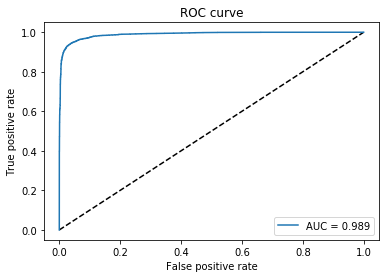

In [14]:
fpr_vgg, tpr_vgg , thresholds_vgg = roc_curve(Y_test, y_pred_vgg)
area_under_curve = auc(fpr_vgg, tpr_vgg)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg, tpr_vgg, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()

In [17]:
precision_vgg , recall_vgg , fscore__vgg ,support__vgg  = sklearn.metrics.precision_recall_fscore_support(Y_test, y_pred_vgg.round(),average='binary')

print ('vgg model precision is: ', precision_vgg)
print ('vgg model recall is: ', recall_vgg)
print ('vgg model fscore  is: ', fscore__vgg)
print ('vgg model support is: ', support__vgg)


vgg model precision is:  0.9509713228492137
vgg model recall is:  0.9518518518518518
vgg model fscore  is:  0.951411383618695
vgg model support is:  None


### ResNet model training and testing on non-augmented data

#### Original Data Training and Testing


In [36]:
res_model_callback = res_callbacks()
res_model_train = res_model (neurons)


res_model_train.compile(
    loss='binary_crossentropy',
    optimizer=opt_SGD,
    metrics=['accuracy']
)
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 3, 2048)        23587712  
_________________________________________________________________
batch_normalization_205 (Bat (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              18875392  
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
__________

In [19]:
#Load weights
res_model_train.load_weights("D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\models\\resnet\\Res_model_history_original_weights.h5")


In [ ]:
#Training
Res_model_history_original = res_model_train.fit(X_train, 
                                       Y_train,
                                       epochs = epochs,
                                       validation_data=(X_validate,Y_validate),
                                       shuffle=True,
                                       batch_size=batch_size,
                                       callbacks = res_model_callback,
                                       verbose = 1)


In [ ]:
res_model_train.save("D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\models\\resnet\\Res_model_history_original.h5")
res_model_train.save_weights("D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\models\\resnet\\Res_model_history_original_weights.h5")

In [ ]:
show_final_history(Res_model_history_original)
print("Validation Accuracy: " + str(Res_model_history_original.history['val_acc'][-1:]))

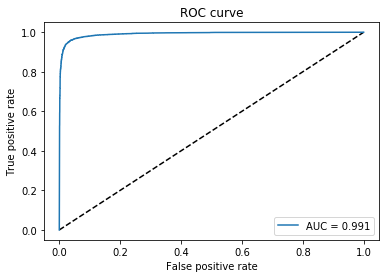

In [21]:
y_pred_res = res_model_train.predict(X_test).ravel()
fpr_res, tpr_res , thresholds_res = roc_curve(Y_test, y_pred_res)
area_under_curve = auc(fpr_res, tpr_res)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_res, tpr_res, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()

In [20]:

precision_res , recall_res , fscore__res ,support__res  = sklearn.metrics.precision_recall_fscore_support(Y_test, y_pred_res.round(),average='binary')

print ('res model precision is: ', precision_res)
print ('res model recall is: ', recall_res)
print ('res model fscore  is: ', fscore__res)
print ('res model support is: ', support__res)


res model precision is:  0.9795640326975477
res model recall is:  0.932037037037037
res model fscore  is:  0.9552097172138926
res model support is:  None


In [22]:
#Testing
Res_model_original_score = res_model_train.evaluate(X_test, Y_test, verbose=1)


10800/10800 [==============================] - ETA: 5: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 56s - ETA: 53 - ETA: 50 - ETA: 47 - ETA: 45 - ETA: 44 - ETA: 42 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ET

In [23]:
print('Res Test loss:', Res_model_original_score[0])
print('Res Test accuracy:', Res_model_original_score[1])

Res Test loss: 0.2052152579821241
Res Test accuracy: 0.9562962962962963


### DenseNet model training and testing on non-augmented data


#### Original Data Training and Testing

In [37]:
dense_model_callback = Dense_callbacks()
dense_model_train = dense_model (neurons)


dense_model_train.compile(
    loss='binary_crossentropy',
    optimizer=opt_SGD,
    metrics=['accuracy']
)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 3, 3, 1024)        7037504   
_________________________________________________________________
batch_normalization_206 (Bat (None, 3, 3, 1024)        4096      
_________________________________________________________________
flatten_7 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              9438208   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
__________

In [22]:
# Load Weights
dense_model_train.load_weights("D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\models\\DenseNet\\dense_model_history_original_weights.h5")

In [ ]:
#Training
dense_model_history_original = dense_model_train.fit(X_train,
                                            Y_train,
                                            epochs = epochs,
                                            validation_data=(X_validate,Y_validate),
                                            shuffle=True,
                                            batch_size=batch_size,
                                            callbacks = original_model_callback,
                                            verbose = 1)


In [ ]:
dense_model_train.save("D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\models\\DenseNet\\dense_model_history_original.h5")
dense_model_train.save_weights("D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\models\\DenseNet\\dense_model_history_original_weights.h5")

In [ ]:
show_final_history(dense_model_history_original)
print("Validation Accuracy: " + str(dense_model_history_original.history['val_acc'][-1:]))

In [32]:
#Testing
dense_model_original_score = dense_model_train.evaluate(X_test, Y_test, verbose=1)


10800/10800 [==============================] - ETA: 15:3 - ETA: 8:0 - ETA: 5: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 -

In [33]:
print('dense Test loss:', dense_model_original_score[0])
print('dense Test accuracy:', dense_model_original_score[1])

dense Test loss: 0.14830372414236923
dense Test accuracy: 0.9652777777777778


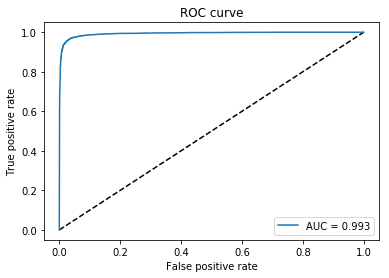

In [35]:
y_pred_dense = dense_model_train.predict(X_test).ravel()
fpr_dense, tpr_dense , thresholds_dense = roc_curve(Y_test, y_pred_dense)
area_under_curve = auc(fpr_dense, tpr_dense )

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dense, tpr_dense , label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()

In [23]:

precision_dense , recall_dense , fscore__dense ,support__dense  = sklearn.metrics.precision_recall_fscore_support(Y_test, y_pred_dense.round(),average='binary')

print ('dense model precision is: ', precision_dense)
print ('dense model recall is: ', recall_dense)
print ('dense model fscore  is: ', fscore__dense)
print ('dense model support is: ', support__dense)


dense model precision is:  0.9667471670072451
dense model recall is:  0.9637037037037037
dense model fscore  is:  0.965223036260781
dense model support is:  None


### InceptionNet model training and testing on non-augmented data


#### Original Data Training and Testing


In [38]:
inception_model_callback = inception_callbacks()
inception_model_train = inception_model (neurons)


inception_model_train.compile(
    loss='binary_crossentropy',
    optimizer=opt_SGD,
    metrics=['accuracy']
)   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1, 1, 1536)        54336736  
_________________________________________________________________
batch_normalization_410 (Bat (None, 1, 1, 1536)        6144      
_________________________________________________________________
flatten_8 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              1573888   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
__________

In [28]:
# Load Weights
inception_model_train.load_weights("D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\models\\inception\\inception_model_history_original_weights.h5")

In [ ]:
#Training
inception_model_history_original = inception_model_train.fit(X_train,
                                            Y_train,
                                            epochs = epochs,
                                            validation_data=(X_validate,Y_validate),
                                            shuffle=True,
                                            batch_size=batch_size,
                                            callbacks = inception_model_callback,
                                            verbose = 1)


In [ ]:
inception_model_train.save("D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\models\\inception\\inception_model_history_original.h5")
inception_model_train.save_weights("D:\\Documents\\Queens Masc\\Winter 2019\\CISC 867 - Deep Learning\\Course Project\\models\\inception\\inception_model_history_original_weights.h5")

In [ ]:
show_final_history(inception_model_history_original)
print("Validation Accuracy: " + str(inception_model_history_original.history['val_acc'][-1:]))

In [38]:
#Testing
inception_model_original_score = inception_model_train.evaluate(X_test, Y_test, verbose=1)


10800/10800 [==============================] - ETA: 33:3 - ETA: 17:0 - ETA: 11:3 - ETA: 8:4 - ETA: 7: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 

In [39]:
print('inception Test loss:', inception_model_original_score[0])
print('inception Test accuracy:', inception_model_original_score[1])

inception Test loss: 0.23587117292767357
inception Test accuracy: 0.942962962962963


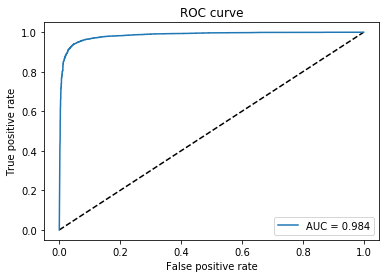

In [40]:
y_pred_inception = inception_model_train.predict(X_test).ravel()
fpr_inception, tpr_inception , thresholds_inception = roc_curve(Y_test, y_pred_inception)
area_under_curve = auc(fpr_inception, tpr_inception)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_inception, tpr_inception, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()

In [29]:

precision_inception , recall_inception , fscore__inception ,support__inception  = sklearn.metrics.precision_recall_fscore_support(Y_test, y_pred_inception.round(),average='binary')

print ('inception model precision is: ', precision_inception)
print ('inception model recall is: ', recall_inception)
print ('inception model fscore  is: ', fscore__inception)
print ('inception model support is: ', support__inception)


inception model precision is:  0.9338048603554588
inception model recall is:  0.9535185185185185
inception model fscore  is:  0.9435587319039765
inception model support is:  None
